In [1]:
import numpy as np
import h5py
import sys
import unet_uae_filter_16_32_32_64 as vae_util


from layers import *
 
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, concatenate, TimeDistributed, RepeatVector, ConvLSTM2D
from convolutional_recurrent_3d import ConvLSTM3D
from keras.models import Model

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 

# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.99
K.tensorflow_backend.set_session(tf.Session(config=config))

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [3]:
data_dir = './data'
# load training data
data_path = os.path.join('/data/cees/sujiang/surrogate_3D/sim_0.1/40x40x20/channel_40x40x20_21tsteps_2924_satifying_cases_update.h5')
p_t, logk = load_data(data_path, ['pressure', 'logk'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('p_t shape is ', p_t.shape)
print('logk shape is ', logk.shape)

p_t shape is  (2924, 20, 40, 40, 21)
logk shape is  (2924, 20, 40, 40, 1)


In [4]:
print('p_t max is ', np.max(p_t))
print('p_t min is ', np.min(p_t))

p_t max is  332.37611780204537
p_t min is  309.13849490489497


In [5]:
depth = 10
nr = logk.shape[0]
train_nr = 100
test_nr = 20

In [6]:
p_t_mean = np.mean(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t = p_t - p_t_mean
print('max p is ', np.max(p_t[:train_nr, ...]), ', min p is ', np.min(p_t[:train_nr, ...]))
max_p = np.max(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)
min_p = np.min(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)

max p is  9.839277713899833 , min p is  -10.277608968486788


In [7]:
epsilon = 1e-6
p_t = (p_t - min_p)/(max_p - min_p + 1e-6)

In [8]:
print('max p is ', np.max(p_t), ', min p is ', np.min(p_t))
print('max p train is ', np.max(p_t[:train_nr, ...]), ', min p train is ', np.min(p_t[:train_nr, ...]))
print('max p validation is ', np.max(p_t[test_nr:, ...]), ', min p validation is ', np.min(p_t[test_nr:, ...]))

max p is  1.060693911190812 , min p is  -0.08929814287580547
max p train is  0.9999999502905212 , min p train is  0.0
max p validation is  1.060693911190812 , min p validation is  -0.08929814287580547


In [9]:
step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
train_x = np.concatenate([logk[:train_nr, ...], p_t[:train_nr,:, :, :, [0]]], axis = -1)
train_y = p_t[:train_nr, :, :, :, step_index]

test_x = np.concatenate([logk[nr-test_nr:, ...],  p_t[nr-test_nr:, :, :, :, [0]]], axis = -1)
test_y = p_t[nr-test_nr:,:, :, :, step_index]

train_y = train_y.transpose(0, 4, 1, 2, 3)
train_y = train_y[:, :, :, :, :, None]
test_y = test_y.transpose(0, 4, 1, 2, 3)
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (100, 20, 40, 40, 2)
train_y shape is  (100, 10, 20, 40, 40, 1)
test_x shape is  (20, 20, 40, 40, 2)
test_y shape is  (20, 10, 20, 40, 40, 1)


In [11]:
input_shape=(20, 40, 40, 2)
depth = 10
input = Input(shape=input_shape, name='image')
_, vae_model_base, _ = vae_util.create_vae(input_shape, depth)
output_base = vae_model_base(input)
# vae_model_base.summary(line_length=150)
output = TimeDistributed(Conv3D(1, (3, 3, 3), padding='same', activation=None))(output_base)
vae_model_fine = Model(input, output) 
vae_model_fine.summary(line_length=150)





output shape is  (None, 10, 20, 40, 40, 16)
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
image (InputLayer)                                                 (None, 20, 40, 40, 2)                                       0                      
______________________________________________________________________________________________________________________________________________________
model_1 (Model)                                                    (None, 10, 20, 40, 40, 16)                                  1807872                
______________________________________________________________________________________________________________________________________________________
time_distributed_32 (TimeDistributed)         

In [12]:
output_dir = 'saved_models_2x2x2/'
vae_model_fine.load_weights(output_dir + 'transfer_saved-model-10steps-bs4-lr3e-4-pressure-detrend-hd-500-filter_16_32_32_64-mse-300-317.93.h5')

In [13]:
vae_model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 20, 40, 40, 2)     0         
_________________________________________________________________
model_1 (Model)              (None, 10, 20, 40, 40, 16 1807872   
_________________________________________________________________
time_distributed_32 (TimeDis (None, 10, 20, 40, 40, 1) 433       
Total params: 1,808,305
Trainable params: 1,807,217
Non-trainable params: 1,088
_________________________________________________________________


In [14]:
epochs = 300
train_nr = train_x.shape[0]
test_nr = 20
batch_size = 4
num_batch = int(train_nr/batch_size) 

In [15]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def hard_data_loss(x, t_decoded):
    '''Compute Hard Data at Well Loc'''
    
    well_loc_x = [14, 4, 37, 36, 9, 21]
    well_loc_y = [31, 19, 3, 21, 4, 3]
    result = 0.
    for i in range(len(well_loc_x)):
        result = result + K.sum((K.batch_flatten(x[:, :, :, well_loc_y[i], well_loc_x[i], :]) - K.batch_flatten(t_decoded[:, :, :, well_loc_y[i], well_loc_x[i], :]))**2, axis = -1)
    return K.mean(result)

def joint_loss(x, t_decoded):
    return vae_loss(x, t_decoded) + 500 * hard_data_loss(x, t_decoded)

In [16]:
def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / (x + 0.0001))

In [17]:
opt = Adam(lr=3e-4)
vae_model_fine.compile(loss = joint_loss, optimizer = opt, metrics = [vae_loss, hard_data_loss, relative_error])

In [18]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 10, cooldown = 1, verbose = 1, min_lr = 1e-7)
filePath = 'saved_models_2x2x2/fine_saved-model-10steps-bs4-lr3e-4-pressure-detrend-hd-500-filter_16_32_32_64-mse-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', period = 20)

callbacks_list = [lrScheduler, checkPoint]

In [19]:
history = vae_model_fine.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y), callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 100 samples, validate on 20 samples
Epoch 1/300
100/100 [==============================] - 24s 235ms/step - loss: 244.2723 - vae_loss: 205.5400 - hard_data_loss: 0.0774 - relative_error: 0.0293 - val_loss: 173.6920 - val_vae_loss: 140.2636 - val_hard_data_loss: 0.0668 - val_relative_error: 0.0311
Epoch 2/300
100/100 [==============================] - 10s 96ms/step - loss: 109.8240 - vae_loss: 93.2665 - hard_data_loss: 0.0330 - relative_error: 0.0250 - val_loss: 149.1999 - val_vae_loss: 125.9964 - val_hard_data_loss: 0.0463 - val_relative_error: 0.0287
Epoch 3/300
100/100 [==============================] - 10s 97ms/step - loss: 87.8091 - vae_loss: 72.8865 - hard_data_loss: 0.0297 - relative_error: 0.0222 - val_loss: 145.0920 - val_vae_loss: 119.9221 - val_hard_data_loss: 0.0502 - val_relative_error: 0.0287
Epoch 4/300
100/100 [==============================] - 10s 96ms/step - loss: 8

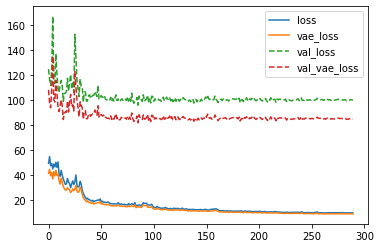

In [21]:
import pickle
with open('results/HISTORY-pressure-fine-tune-mse-hd500-filter_16_32_32_64.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
                
plt.figure()
plt.plot(history.history['loss'][10:300], label = 'loss')
plt.plot(history.history['vae_loss'][10:300], label = 'vae_loss')
plt.plot(history.history['val_loss'][10:300], '--', label = 'val_loss')
plt.plot(history.history['val_vae_loss'][10:300], '--', label = 'val_vae_loss')
plt.legend()
plt.show()

In [22]:
exit()